In [1]:
from pyiron_atomistics import Project
import numpy as np
from typing import Optional

In [2]:
from pyiron_workflow import Workflow
from pyironflow.pyironflow import PyironFlow

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
@Workflow.wrap.as_function_node
def CreateProject(pr_name:str):
    pr = Project(pr_name)
    import os
    os.system('conda env export | grep -v "^prefix: " > ' + pr.path + pr.name + '_environment.yml')
    return pr

In [5]:
@Workflow.wrap.as_function_node
def CreateStructure(pr, structure_name_prefix: str, element:str, bravais_lattice: Optional[str], a: Optional[float|int], c: Optional[float|int] = None, cubic:bool = False):

    import json
    from pyiron_base.storage.hdfio import FileHDFio
    from ob.concept_dict import process_structure_crystal, get_unit_cell_parameters
    
    pr = pr
    if bravais_lattice != 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    elif bravais_lattice == 'hcp' and c == None:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a)
    else:
        structure = pr.create.structure.bulk(element, crystalstructure=bravais_lattice, cubic=cubic, a=a, c=c)

    structure_path = pr.name + '/'
    structure_name = structure_name_prefix + '_input_structure'
    hdf = FileHDFio(structure_path + structure_name + '.h5')
    structure.to_hdf(hdf)

    # Must be conventional unit cell or primitive cell
    # Provide the structure before repetition or any other manipulations
    structure_parameters = get_unit_cell_parameters(structure)
    
    struct_cdict = process_structure_crystal(pr, structure, structure_name, structure_path, structure_parameters)
    
    struct_and_cdict = {'object': structure, 'cdict': struct_cdict}
    
    return struct_and_cdict

In [6]:
@Workflow.wrap.as_function_node("View")
def VisualizeStructure(struct_and_dict):
    return struct_and_dict['object'].plot3d

In [7]:
@Workflow.wrap.as_function_node
def LammpsCalcMinimize(pr, struct_and_cdict, job_name:str, pot_list_index:int, f_tol:float|int, min_style:str, del_ex_job:bool = False, is_child_job = False):
    
    from ob.concept_dict import process_lammps_job
    pr = pr
    structure = struct_and_cdict['object']
    job = pr.create.job.Lammps(job_name=job_name, delete_existing_job=del_ex_job)
    job.structure = structure.copy()
    job.potential = job.list_potentials()[68]
    job.calc_minimize(ionic_force_tolerance=f_tol)

    job_cdict = {} #process_lammps_job(job)

    if is_child_job == False:
        import os
        os.system('conda env export | grep -v "^prefix: " > ' + job.path + '_environment.yml')
    
        from pyiron_base.storage.hdfio import FileHDFio
        hdf = FileHDFio(job.path + '_input_structure.h5')
        job.structure.to_hdf(hdf)
        job_cdict = process_lammps_job(job)
    
    job_and_cdict = {'object': job, 'cdict': job_cdict}
    
    return job_and_cdict

In [8]:
@Workflow.wrap.as_function_node
def MurnaghanJob(pr, job_and_cdict, murn_job_name:str, n_sample_points:int, equation_of_state:str, fit_order:int, volume_range:float|int, 
                 del_ex_job:bool = False):
    
    from ob.concept_dict import process_murnaghan_job, process_lammps_job
    
    job = job_and_cdict['object']
    pr = pr
    murn = job.create_job(job_type=pr.job_type.Murnaghan, job_name=murn_job_name, delete_existing_job=del_ex_job)
    murn.input['fit_type'] = equation_of_state
    murn.input['num_points'] = n_sample_points
    murn.input['fit_order'] = fit_order
    murn.input['vol_range'] = volume_range
    murn.run()

    import os
    os.system('conda env export | grep -v "^prefix: " > ' + murn.path + '_environment.yml')

    child_jobs_cdict = []
    for jobs in murn.iter_jobs():
        from pyiron_base.storage.hdfio import FileHDFio
        os.system('cp ' + murn.path + '_environment.yml ' + jobs.path + '_environment.yml')
        child_cdict = process_lammps_job(jobs)
        child_jobs_cdict.append(child_cdict)

    job_cdict = process_murnaghan_job(murn)

    murn_job_and_cdict = {'object': murn, 'cdict': job_cdict, 'children_cdict': child_jobs_cdict}
    
    return murn_job_and_cdict

In [9]:
@Workflow.wrap.as_dataclass_node
class MurnaghanParameters():
    murn_job_name: Optional[str] = 'murn'
    n_sample_points: Optional[int] = 7
    equation_of_state: Optional[str] = 'birchmurnaghan'
    fit_order: Optional[int] = 3
    volume_range: Optional[float|int] = 0.05
    job_name: Optional[str] = 'el_str'
    pot_list_index: Optional[int] = 0
    f_tol: Optional[float|int] = 1e-6
    min_style: Optional[str] = 'cg'

In [10]:
@Workflow.wrap.as_macro_node("murn_job_and_cdict")
def MurnaghanLammpsMacro(self, pr, struct_and_cdict, parameters: Optional[MurnaghanParameters.dataclass] = MurnaghanParameters.dataclass(), 
                         del_ex_job:bool = False):
    
    self.engine = LammpsCalcMinimize(pr, struct_and_cdict, parameters.job_name, parameters.pot_list_index, parameters.f_tol, parameters.min_style, del_ex_job, True)
    
    self.murn_job_and_cdict = MurnaghanJob(pr, self.engine, parameters.murn_job_name, parameters.n_sample_points, parameters.equation_of_state, parameters.fit_order, 
                                           parameters.volume_range, del_ex_job)
    
    return self.murn_job_and_cdict

In [11]:
@Workflow.wrap.as_function_node
def ExtractEquilibriumStructure(murn_job_and_cdict):

    import json
    from pyiron_base.storage.hdfio import FileHDFio
    from ob.concept_dict import process_structure_crystal, get_unit_cell_parameters

    murn_job = murn_job_and_cdict['object']
    equil_structure = murn_job.get_structure()
    structure_name = murn_job.name + '_equilibrium_structure'
    structure_path = murn_job.project.name + '/'
    hdf_equil = FileHDFio(structure_path + structure_name + '.h5')
    equil_structure.to_hdf(hdf_equil)

    # Must be conventional unit cell or primitive cell
    # Provide the structure before repetition or any other manipulations
    structure_parameters = get_unit_cell_parameters(equil_structure)
    
    struct_cdict = process_structure_crystal(murn_job.project, equil_structure, structure_name, structure_path, structure_parameters)
    
    equil_struct_and_cdict = {'object': equil_structure, 'cdict': struct_cdict}
    
    return equil_struct_and_cdict   

In [12]:
@Workflow.wrap.as_function_node
def CombinedPlots(pr, murn_job_bcc_and_cdict, murn_job_fcc_and_cdict, murn_job_hcp_and_cdict):

    murn_job_bcc = murn_job_bcc_and_cdict['object']
    murn_job_fcc = murn_job_fcc_and_cdict['object']
    murn_job_hcp = murn_job_hcp_and_cdict['object']
    
    y_bcc = murn_job_bcc.output_to_pandas()['energy'].to_numpy()/2
    x_bcc = murn_job_bcc.output_to_pandas()['volume'].to_numpy()/2
    y_fcc = murn_job_fcc.output_to_pandas()['energy'].to_numpy()/4
    x_fcc = murn_job_fcc.output_to_pandas()['volume'].to_numpy()/4
    y_hcp = murn_job_hcp.output_to_pandas()['energy'].to_numpy()/2
    x_hcp = murn_job_hcp.output_to_pandas()['volume'].to_numpy()/2

    from scipy.interpolate import make_interp_spline

    idx_bcc = x_bcc
    xnew_bcc = np.linspace(min(idx_bcc), max(idx_bcc), 300)
    spl_bcc = make_interp_spline(idx_bcc, y_bcc, k=3)
    smooth_bcc = spl_bcc(xnew_bcc)

    idx_fcc = x_fcc
    xnew_fcc = np.linspace(min(idx_fcc), max(idx_fcc), 300)
    spl_fcc = make_interp_spline(idx_fcc, y_fcc, k=3)
    smooth_fcc = spl_fcc(xnew_fcc)

    idx_hcp = x_hcp
    xnew_hcp = np.linspace(min(idx_hcp), max(idx_hcp), 300)
    spl_hcp = make_interp_spline(idx_hcp, y_hcp, k=3)
    smooth_hcp = spl_hcp(xnew_hcp)

    plt.grid()
    plt.scatter(x_bcc, y_bcc)
    plt.plot(xnew_bcc, smooth_bcc, label="Body Centerd Cubic (BCC)")
    plt.scatter(x_fcc, y_fcc)
    plt.plot(xnew_fcc, smooth_fcc, label="Face Centered Cubic (FCC)")
    plt.scatter(x_hcp, y_hcp)
    plt.plot(xnew_hcp, smooth_hcp, label="Hexagonal Close Packed (HCP)")
    plt.legend(loc='best')
    plt.xlabel("Volume per atom [$\mathrm{\AA}^3$]")
    plt.ylabel("Energy per atom [eV]")
    plt.xlim(9.5,12.5)
    plt.ylim(-4.04,-3.92)
    plt.title("Energy-Volume Curves of Iron (Fe)\n\nPotential: 2022--Sun-Y--Fe--LAMMPS--ipr1")

    eq_dict = {
        'Structures': ['EquilibriumEnergy/Atom', 'EquilibriumVolume/Atom', 'BulkModulus', 'BulkModulusPrime'],
        'BCC': [murn_job_bcc.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/2,
                   murn_job_bcc.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/2,
                   murn_job_bcc.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_bcc.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],
        'FCC': [murn_job_fcc.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/4,
                   murn_job_fcc.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/4,
                   murn_job_fcc.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_fcc.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],
        'HCP': [murn_job_hcp.output_to_pandas()['equilibrium_energy'].to_numpy()[0]/2,
                   murn_job_hcp.output_to_pandas()['equilibrium_volume'].to_numpy()[0]/2,
                   murn_job_hcp.output_to_pandas()['equilibrium_bulk_modulus'].to_numpy()[0],
                   murn_job_hcp.output_to_pandas()['equilibrium_b_prime'].to_numpy()[0]],

    }

    import pandas as pd
    df = pd.DataFrame.from_dict(eq_dict, orient='index')
    df.style.set_caption("Summary")
    df.style.hide()
    df.columns = df.iloc[0]
    df = df[1:]

    save_location = str(pr.name) + '/'
    plt.savefig(save_location + 'combined_plot.png')
    df.to_csv(save_location + 'summary.csv')

    plt.show()
    
    return df

In [13]:
wf_code = Workflow("try1")

wf_code.CreateProject = CreateProject(pr_name="try1_Fe")

wf_code.CreateStructure0 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_bcc", element="Fe", bravais_lattice="bcc", a=2.845, cubic=True)
wf_code.VisualizeStructure0 = VisualizeStructure(wf_code.CreateStructure0)

wf_code.CreateStructure1 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_fcc", element="Fe", bravais_lattice="fcc", a=3.43, cubic=True)
wf_code.VisualizeStructure1 = VisualizeStructure(wf_code.CreateStructure1)

wf_code.CreateStructure2 = CreateStructure(pr=wf_code.CreateProject, structure_name_prefix="try1_Fe_hcp", element="Fe", bravais_lattice="hcp", a=2.435)
wf_code.VisualizeStructure2 = VisualizeStructure(wf_code.CreateStructure2)

wf_code.MurnaghanParameters0 = MurnaghanParameters(murn_job_name="try1_murn_Fe_bcc", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_bcc", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanParameters1 = MurnaghanParameters(murn_job_name="try1_murn_Fe_fcc", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_fcc", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanParameters2 = MurnaghanParameters(murn_job_name="try1_murn_Fe_hcp", n_sample_points=7, equation_of_state="birchmurnaghan", volume_range=0.05, 
                                             job_name="try1_Fe_hcp", pot_list_index=68, f_tol=1e-8, min_style="fire")

wf_code.MurnaghanLammpsMacro0 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure0, parameters=wf_code.MurnaghanParameters0, del_ex_job=True)
wf_code.ExtractEquilibriumStructure0 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro0)

wf_code.MurnaghanLammpsMacro1 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure1, parameters=wf_code.MurnaghanParameters1, del_ex_job=True)
wf_code.ExtractEquilibriumStructure1 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro1)

wf_code.MurnaghanLammpsMacro2 = MurnaghanLammpsMacro(pr=wf_code.CreateProject, struct_and_cdict=wf_code.CreateStructure2, parameters=wf_code.MurnaghanParameters2, del_ex_job=True)
wf_code.ExtractEquilibriumStructure2 = ExtractEquilibriumStructure(wf_code.MurnaghanLammpsMacro2)

wf_code.CombinedPlots = CombinedPlots(wf_code.CreateProject, wf_code.MurnaghanLammpsMacro0, wf_code.MurnaghanLammpsMacro1, wf_code.MurnaghanLammpsMacro2)

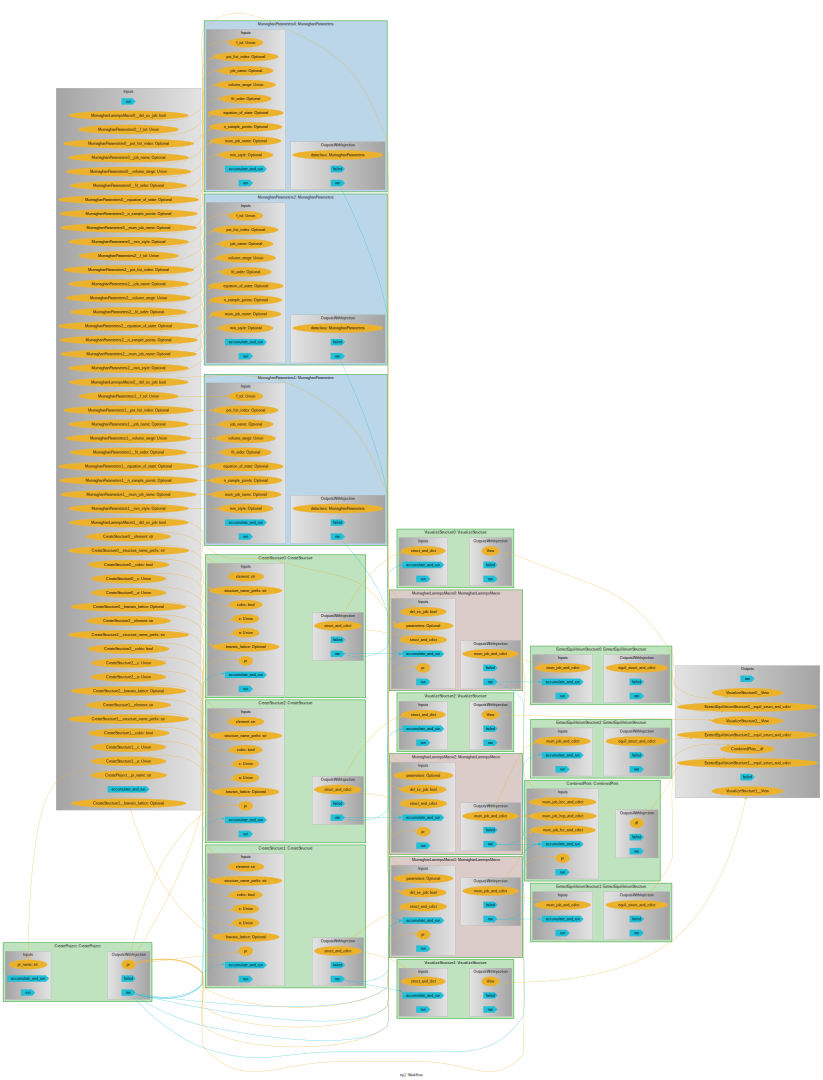

In [30]:
wf_code.draw(size=(15,15))

The job try1_murn_Fe_hcp was saved and received the ID: 3599
The job try1_murn_Fe_hcp_0_95 was saved and received the ID: 3600
The job try1_murn_Fe_hcp_0_9666667 was saved and received the ID: 3601
The job try1_murn_Fe_hcp_0_9833333 was saved and received the ID: 3602
The job try1_murn_Fe_hcp_1_0 was saved and received the ID: 3603
The job try1_murn_Fe_hcp_1_0166667 was saved and received the ID: 3604
The job try1_murn_Fe_hcp_1_0333333 was saved and received the ID: 3605
The job try1_murn_Fe_hcp_1_05 was saved and received the ID: 3606
The job try1_murn_Fe_fcc was saved and received the ID: 3607
The job try1_murn_Fe_fcc_0_95 was saved and received the ID: 3608
The job try1_murn_Fe_fcc_0_9666667 was saved and received the ID: 3609
The job try1_murn_Fe_fcc_0_9833333 was saved and received the ID: 3610
The job try1_murn_Fe_fcc_1_0 was saved and received the ID: 3611
The job try1_murn_Fe_fcc_1_0166667 was saved and received the ID: 3612
The job try1_murn_Fe_fcc_1_0333333 was saved and rece

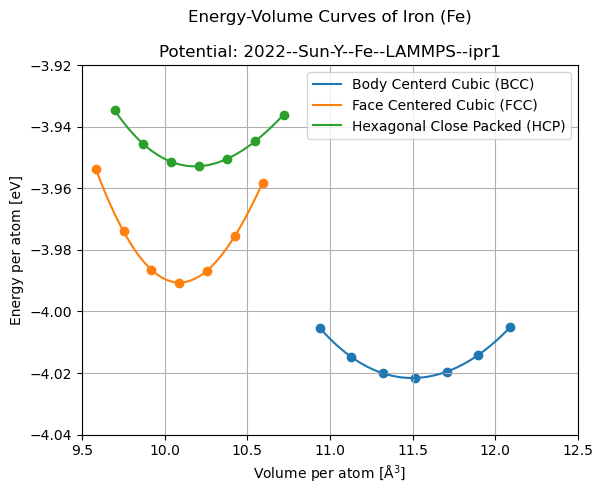

In [14]:
_ = wf_code()

In [32]:
from ob.openbis import openbis_login
o = openbis_login("https://test3.datastore.bam.de/", "tlakshmi")

Enter openBIS password:  ········


In [33]:
o.get_session_info().userName

'tlakshmi'

In [36]:
from ob.openbis import flatten_cdict, GenericCrystalObject, MurnaghanJobObject, GenericLammpsJobObject
ob_structure0 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.CreateStructure0.outputs.struct_and_cdict.value['cdict'])
ob_structure1 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.CreateStructure1.outputs.struct_and_cdict.value['cdict'])
ob_structure2 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.CreateStructure2.outputs.struct_and_cdict.value['cdict'])
ob_murn_job0 = MurnaghanJobObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.MurnaghanLammpsMacro0.outputs.murn_job_and_cdict.value['cdict'], wf_code.MurnaghanLammpsMacro0.outputs.murn_job_and_cdict.value['children_cdict'])
ob_murn_job1 = MurnaghanJobObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.MurnaghanLammpsMacro1.outputs.murn_job_and_cdict.value['cdict'], wf_code.MurnaghanLammpsMacro1.outputs.murn_job_and_cdict.value['children_cdict'])
ob_murn_job2 = MurnaghanJobObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.MurnaghanLammpsMacro2.outputs.murn_job_and_cdict.value['cdict'], wf_code.MurnaghanLammpsMacro2.outputs.murn_job_and_cdict.value['children_cdict'])
ob_equil_structure0 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.ExtractEquilibriumStructure0.outputs.equil_struct_and_cdict.value['cdict'])
ob_equil_structure1 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.ExtractEquilibriumStructure1.outputs.equil_struct_and_cdict.value['cdict'])
ob_equil_structure2 = GenericCrystalObject(o, 'TLAKSHMI', 'TEST', 'TEST_EXP_1', wf_code.ExtractEquilibriumStructure2.outputs.equil_struct_and_cdict.value['cdict'])
ob_murn_job0.add_parents([ob_structure0])
ob_murn_job0.save()
ob_murn_job1.add_parents([ob_structure1])
ob_murn_job1.save()
ob_murn_job2.add_parents([ob_structure2])
ob_murn_job2.save()
ob_murn_job0.add_children([ob_equil_structure0])
ob_murn_job0.save()
ob_murn_job1.add_children([ob_equil_structure1])
ob_murn_job1.save()
ob_murn_job2.add_children([ob_equil_structure2])
ob_murn_job2.save()


Structure already exists in project! Found structure in: /TLAKSHMI/TEST/MAT_SIM_STR.CRY485


Found structure properties:



property,value,description,type,mandatory
$name,try1_Fe_bcc_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.845,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_Fe_fcc_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,3.43,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_Fe_hcp_input_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.435,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,3.9763,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False



Job already exists! Found job in: /TLAKSHMI/TEST/PYI_JOB.MRN486


Found job properties:



property,value,description,type,mandatory
$name,try1_murn_Fe_bcc,Name,VARCHAR,True
description,Murnaghan job for structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:36:04 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,8.33E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,8.33E-4,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc,Name,VARCHAR,True
description,Murnaghan job for structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:57 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,8.33E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,8.33E-4,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_0_95,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:55 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,2.78E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_0_9666667,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:55 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_0_9833333,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:56 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,2.78E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_1_0,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:56 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_1_0166667,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:56 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_1_0333333,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:57 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,2.78E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_1_05,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:57 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp,Name,VARCHAR,True
description,Murnaghan job for structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:50 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.001111,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.001111,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_0_95,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:48 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,2.78E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_0_9666667,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:48 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_0_9833333,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:48 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_1_0,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:49 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_1_0166667,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:49 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_1_0333333,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:50 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,2.78E-4,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.
sample successfully created.
DataSet successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_1_05,Name,VARCHAR,True
description,Lammps simulation using pyiron for energy minimization/structural optimization.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
bam_username,tlakshmi,BAM username//BAM Benutzername,VARCHAR,True
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
sim_job_finished,True,"Finished = True, Aborted or incomplete = False//Beendet = Wahr, Abgebrochen oder unvollständig = Falsch",BOOLEAN,False
start_date,2024-10-29 17:35:50 +0100,Start date,TIMESTAMP,False
sim_walltime_in_hours,0.0,Total job run time [hr]//Gesamtlaufzeit des Jobs [Stunden],REAL,False
sim_coretime_in_hours,0.0,Total core hours used [hr]//Gesamtkernstundenzeit des Jobs [Stunden],REAL,False
ncores,1,Number of cores used//Anzahl der Kerne,INTEGER,False
ngpus,,Number of GPUs used//Anzahl der GPUs,INTEGER,False


sample successfully updated.

Structure already exists in project! Found structure in: /TLAKSHMI/TEST/MAT_SIM_STR.CRY494


Found structure properties:



property,value,description,type,mandatory
$name,try1_murn_Fe_bcc_equilibrium_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.845,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_fcc_equilibrium_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,3.4302,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully created.
DataSet successfully created.
DataSet successfully created.


property,value,description,type,mandatory
$name,try1_murn_Fe_hcp_equilibrium_structure,Name,VARCHAR,True
description,Crystal structure generated using pyiron.Scroll down below other properties to view conceptual dictionary with ontological ids of selected properties and values.The conceptual dictionary is in JSON-LD format. Learn more about it here,Short description and/or purpose//Kurzbeschreibung und/oder Zweck,MULTILINE_VARCHAR,False
workflow_manager,"pyiron_atomistics=0.6.14, pyiron_workflow=0.11.0, pyironflow=0.0.3,",Workflow manager//Workflow-Manager,VARCHAR,False
crystal_orientation,,Miller indices//Millersche Indizes,VARCHAR,False
lattice_param_a_in_a,2.433,Lattice parameter (a) [Å]//Gitterparameter (a) [Å],REAL,False
lattice_param_b_in_a,,Lattice parameter (b) [Å]//Gitterparameter (b) [Å],REAL,False
lattice_param_c_in_a,3.9731,Lattice parameter (c) [Å]//Gitterparameter (c) [Å],REAL,False
lattice_c_over_a,,Lattice parameter (c over a)//Gitterparameter (c über a),REAL,False
lattice_angalpha_in_deg,90.0,Lattice angle (alpha) [Degrees]//Gitterwinkel (alpha) [Grad],REAL,False
lattice_angbeta_in_deg,90.0,Lattice angle (beta) [Degrees]//Gitterwinkel (beta) [Grad],REAL,False


sample successfully updated.
sample successfully updated.
sample successfully updated.
sample successfully updated.
sample successfully updated.
sample successfully updated.


In [31]:
pf = PyironFlow([wf_code])
pf.gui